# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Loading the dataset

In [2]:
filepath = ".\\KPMG_VI_New_raw_data_update_final.xlsx"

## Transactions Sheet

In [3]:
def load_sheet(sheet_name):
    """
    This function uses pandas,
    to read an excel sheet from a workbook,
    and returns a pandas dataframe
    """
    df = pd.read_excel(filepath, sheet_name=sheet_name, header=1)
    return df

In [4]:
tran_df = load_sheet("Transactions")
tran_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [5]:
tran_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

There are a couple of issues with this dataframe;
1. Missing values in columns:

* online_order,
* brand,
* product_line,
* product_class,
* product_size,  
* standard_cost, and
* product_first_sold_date

2. Incorrect datatype for *product_first_sold_date* column

### Exploratory Data Analysis

In [6]:
tran_df['product_id'].nunique()

101

In [7]:
tran_df['customer_id'].nunique()

3494

In [8]:
tran_df['transaction_id'].max()

20000

We have 101 unique products sold to 3494 unique customers over 20,000 transactions, in this transactions sheet.

In [9]:
#converting serial date format to datetime
import xlrd

def convert_date(serial_date):
    """
    This function takes in a date in serial format,
    and converts it into pandas datetime format,
    using xlrd library
    """
    date_time_date = xlrd.xldate_as_datetime(serial_date, 0)
    date_object = date_time_date.date()
    return date_object

In [10]:
tran_df['product_first_sold_date'].describe()

count    19803.000000
mean     38199.776549
std       2875.201110
min      33259.000000
25%      35667.000000
50%      38216.000000
75%      40672.000000
max      42710.000000
Name: product_first_sold_date, dtype: float64

In [11]:
#filling in missing date values with mode
tran_df['product_first_sold_date'].fillna(tran_df['product_first_sold_date'].mode()[0], inplace=True)

In [12]:
#using convert_date function to convert the dates in product_first_sold_date column
tran_df['product_first_sold_date'] = tran_df['product_first_sold_date'].apply(convert_date)

In [13]:
tran_df['product_first_sold_date'].head()

0    2012-12-02
1    2014-03-03
2    1999-07-20
3    1998-12-16
4    2015-08-10
Name: product_first_sold_date, dtype: object

#### Question
Which is the most sold product line?

In [14]:
product_line_sales = tran_df['transaction_id'].groupby(tran_df['product_line']).count()
product_line_sales.sort_values(ascending=False)

product_line
Standard    14176
Road         3970
Touring      1234
Mountain      423
Name: transaction_id, dtype: int64

The **Standard** product line is the most sold, whilst the **Mountain** is the least sold.

#### Question
Which brand is the most valueable ?

In [15]:
average_brand_value = tran_df['list_price'].groupby(tran_df['brand']).mean()
average_brand_value.sort_values(ascending=False)

brand
WeareA2B          1263.454813
Giant Bicycles    1235.407204
Trek Bicycles     1183.783398
Solex             1057.271956
OHM Cycles         983.706983
Norco Bicycles     913.202450
Name: list_price, dtype: float64

The **WeareA2B** brand is the most valueable, and the **Norco Bicycles** the least.

#### Question 
What is the Sales trend over time?
1. Total Sales over time

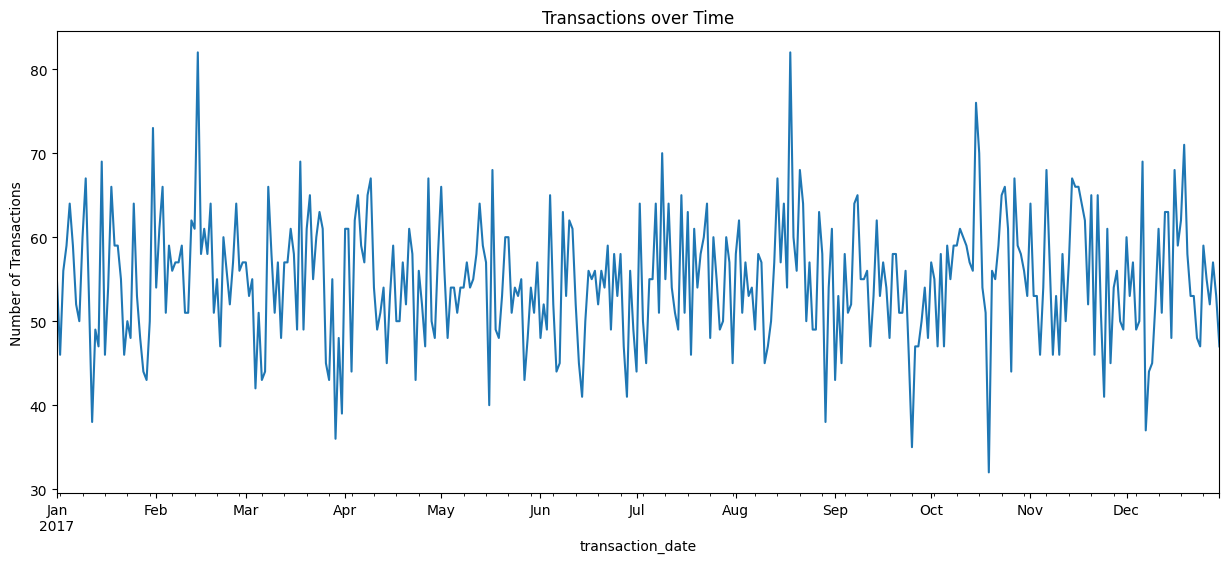

In [21]:
#grouping total number of transactions by transaction date
total_transactions = tran_df['transaction_id'].groupby(tran_df['transaction_date']).count()

plt.figure(figsize=(15,6))
plt.title("Transactions over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
total_transactions.plot();

No discernible patterns on this timeline.

2. Sales amount over time

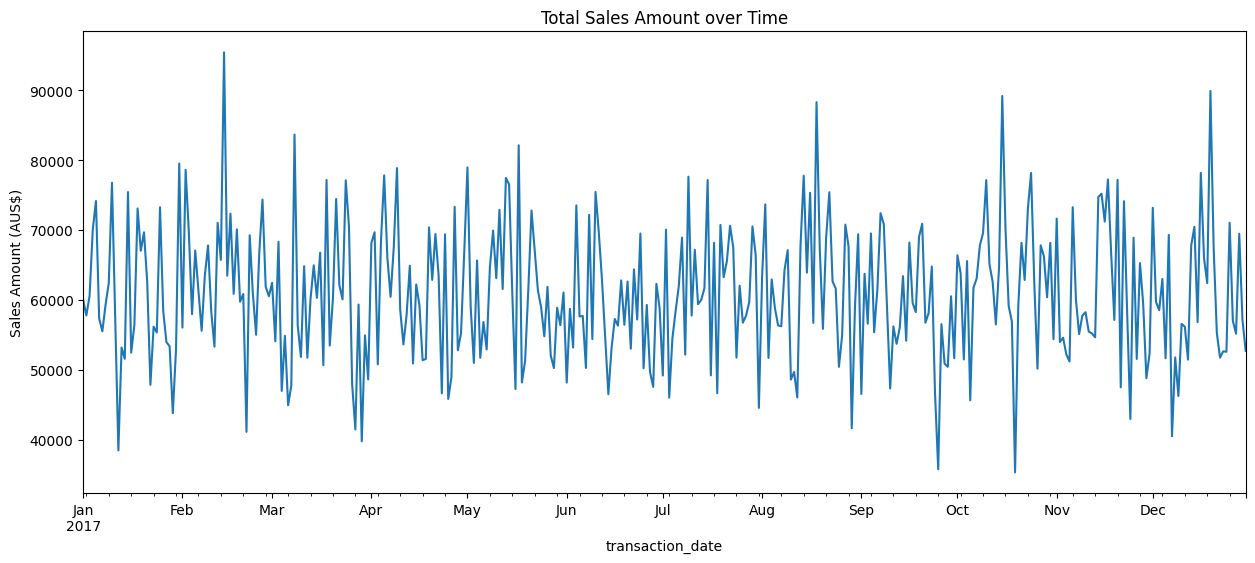

In [25]:
#grouping sum of transactions value by transaction date
total_transactions = tran_df['list_price'].groupby(tran_df['transaction_date']).sum()

plt.figure(figsize=(15,6))
plt.title("Total Sales Amount over Time")
plt.xlabel("Date")
plt.ylabel("Sales Amount (AUS$)")
total_transactions.plot();

From these 2 plots it seems like the Sales amount is correlated somehow to the total number of transactions. Lets investigate this.

In [26]:
# grouping sales, sales amount by time
tran_sales = tran_df.groupby([pd.Grouper(key='transaction_date')]).agg(number_of_sales=('transaction_id', 'nunique'), sales_amount=('list_price', 'sum') )
tran_sales.head()

,number_of_sales,sales_amount
transaction_date,,
2017-01-01,55,60029.45
2017-01-02,46,57765.79
2017-01-03,56,60563.34
2017-01-04,59,70048.39
2017-01-05,64,74153.32


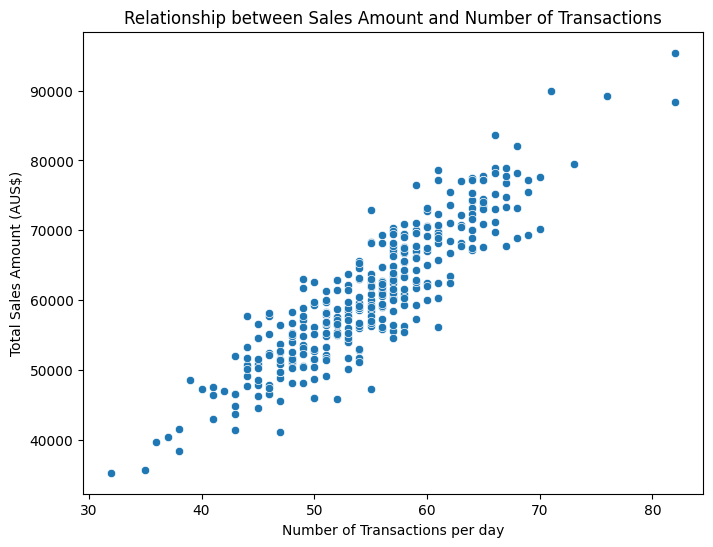

In [29]:
plt.figure(figsize=(8,6))
plt.title("Relationship between Sales Amount and Number of Transactions")
plt.xlabel("Number of Transactions per day")
plt.ylabel("Total Sales Amount (AUS$)")
sns.scatterplot(
    data = tran_sales,
    x = 'number_of_sales',
    y = 'sales_amount'
);

The total sales amount is positively correlated to the number of transactions per day.

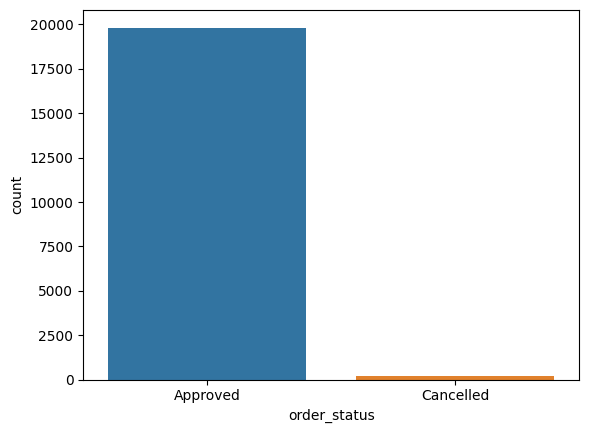

In [30]:
sns.countplot(
    data = tran_df,
    x = 'order_status'
);

More than 90% of the orders are Approved. But what product_line is being cancelled the most?

In [31]:
cancelled_df = tran_df.query('order_status == "Cancelled"')

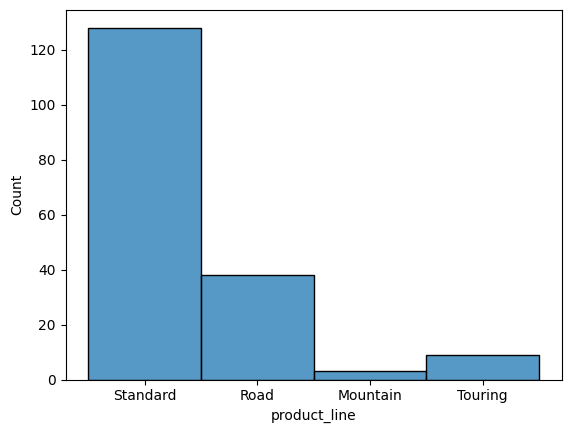

In [33]:
sns.histplot(
    data = cancelled_df,
    x = 'product_line'
);

The Standard product line is being cancelled the most.

In [34]:
tran_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10
